In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

COMPLETE HALL EFFECT AND CONDUCTIVITY ANALYSIS
Sample A - Germanium

Data Summary:
Temperature range: -180°C to 150°C
Number of data points: 34

Generating plots...


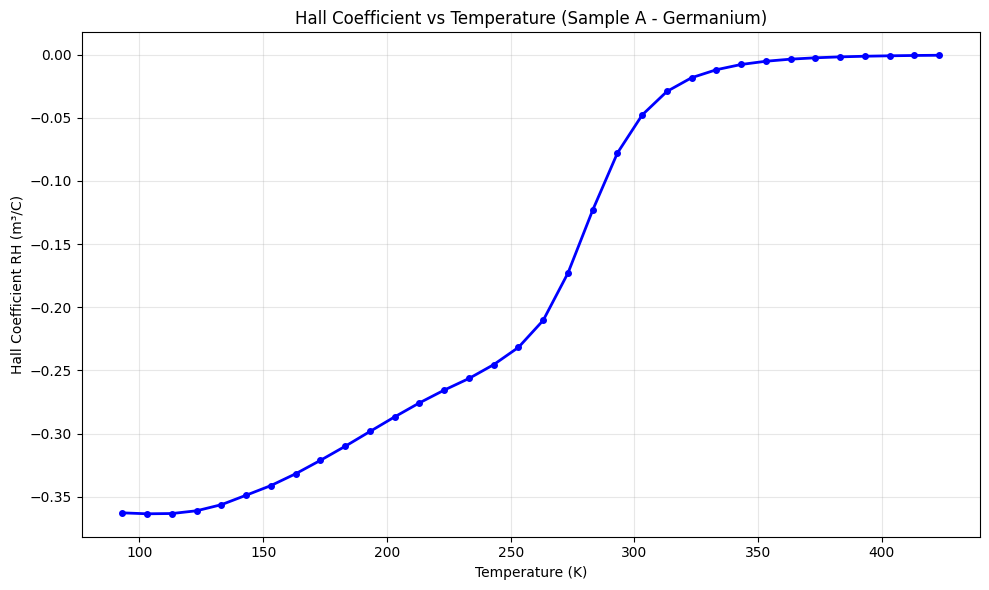

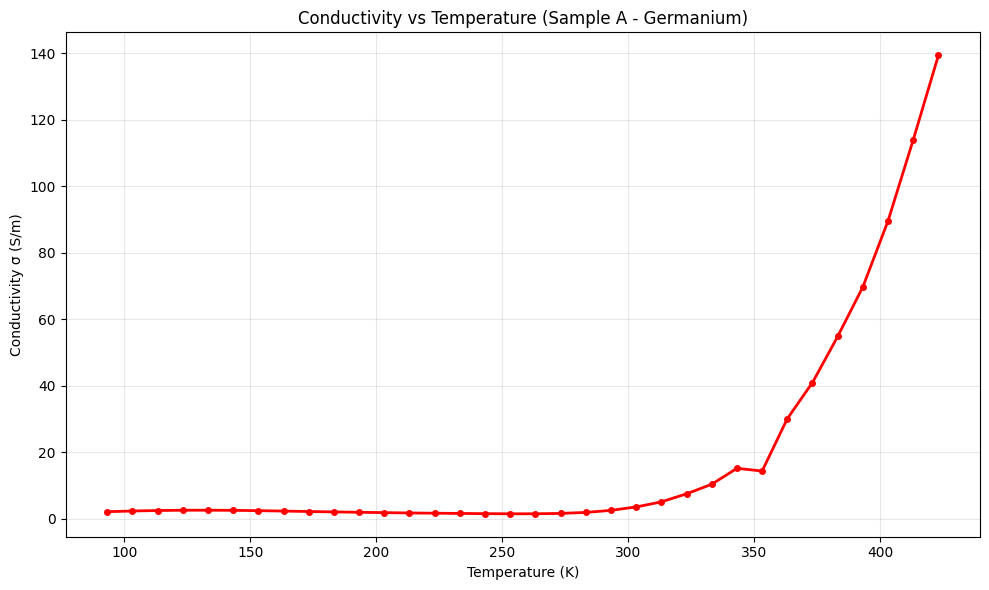

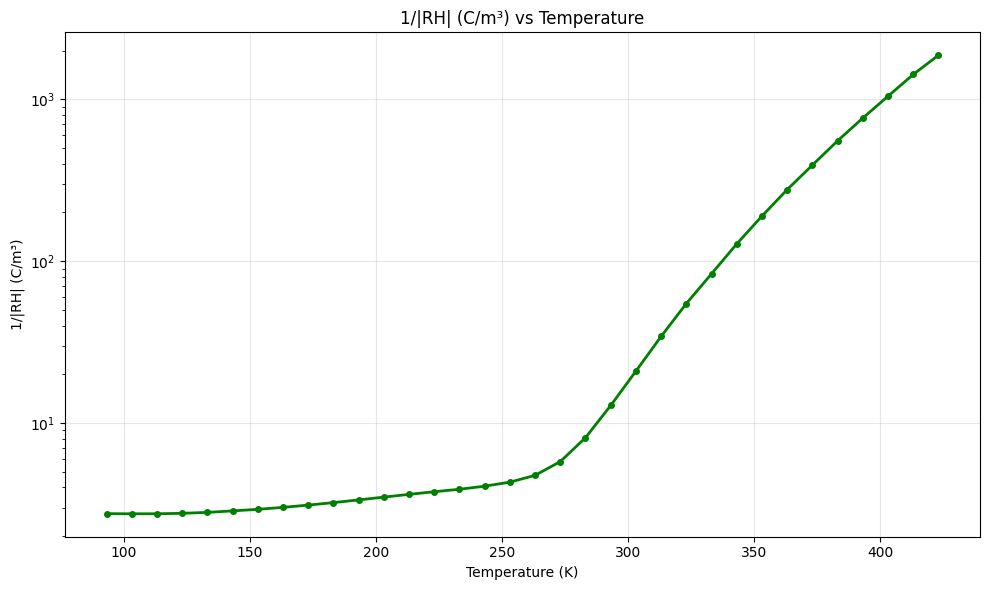

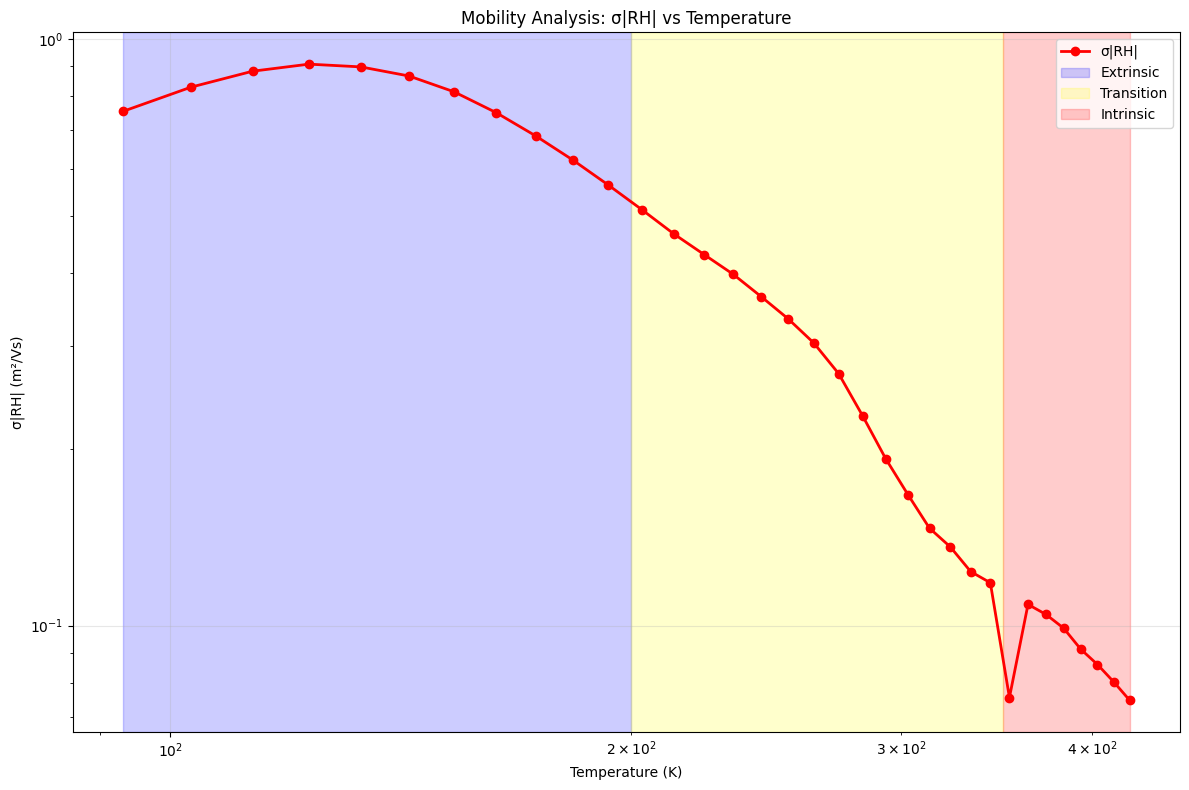


CHARGE CARRIER TYPE ANALYSIS
Average Hall coefficient in extrinsic region: -3.42e-01 m³/C
Average Hall voltage in extrinsic region: -1.71e-01 V

✓ RH < 0: Majority charge carriers are ELECTRONS (n-type)
✓ The semiconductor is n-doped (donor doping)

INTRINSIC CARRIER CONCENTRATION ANALYSIS
Temperature range for intrinsic region: 353.1 - 423.1 K
Number of data points in intrinsic region: 8

Intrinsic carrier concentrations:
T = 353.1 K: ni = 2.77e+14 cm⁻³
T = 363.1 K: ni = 4.09e+14 cm⁻³
T = 373.1 K: ni = 5.86e+14 cm⁻³
T = 383.1 K: ni = 8.38e+14 cm⁻³
T = 393.1 K: ni = 1.17e+15 cm⁻³
T = 403.1 K: ni = 1.62e+15 cm⁻³
T = 413.1 K: ni = 2.23e+15 cm⁻³
T = 423.1 K: ni = 2.96e+15 cm⁻³


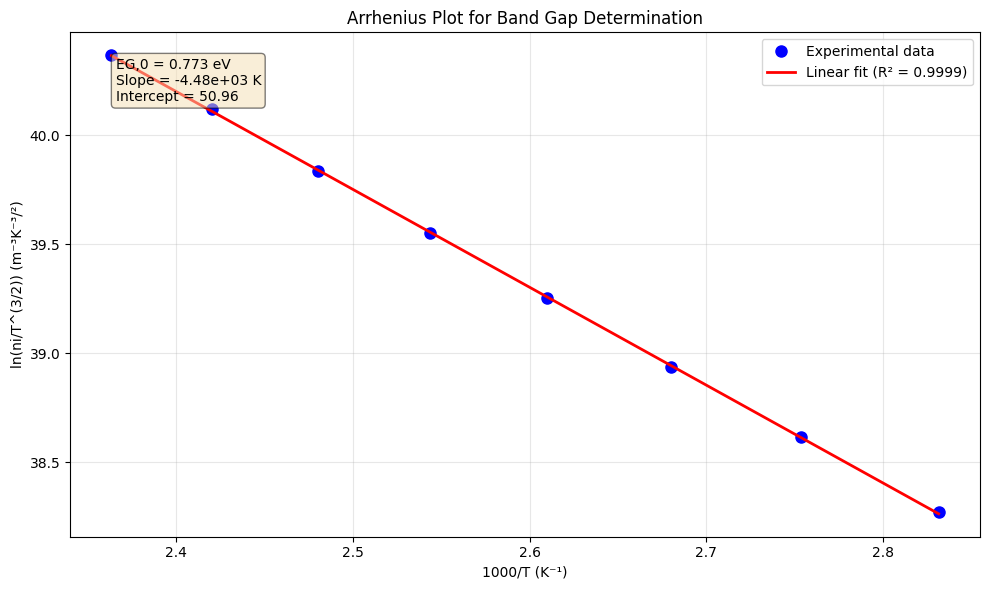


ARRHENIUS ANALYSIS RESULTS
Slope: -4.48e+03 K
Intercept: 50.96
R² value: 0.9999
Band gap EG,0: 0.773 eV
Literature EG,0 for Ge: ~0.74 eV

ni(300K) CALCULATION
Calculated ni(300K): 2.27e+13 cm⁻³
Literature value: 2.40e+13 cm⁻³
Relative difference: 5.3%

EG(300K) CALCULATION
EG,0 (extrapolated): 0.773 eV
Temperature coefficient α: 4e-04 eV/K
Calculated EG(300K): 0.653 eV
Literature value: 0.660 eV
Absolute difference: 7.1 meV

ANALYSIS COMPLETE
All plots have been saved as PNG files.

Final Data Summary:
              T_K        R_H  conductivity   inv_abs_RH  sigma_abs_RH
count   34.000000  34.000000     34.000000    34.000000     34.000000
mean   258.150000  -0.177561     18.711590   203.511972      0.396233
std     99.582462   0.148296     34.700376   439.779584      0.298806
min     93.150000  -0.363570      1.439394     2.750502      0.074606
25%    175.650000  -0.318455      1.861526     3.140895      0.119684
50%    258.150000  -0.221110      2.450261     4.533252      0.318494
7

In [33]:

class HallEffectAnalyzer:
    def __init__(self, csv_file='Exp_4.csv'):
        """
        Initialize the Hall Effect Analyzer
        
        Parameters:
        csv_file (str): Path to the CSV data file
        """
        # Physical constants
        self.e = 1.602e-19  # Elementary charge [C]
        self.k_B = 1.381e-23  # Boltzmann constant [J/K]
        self.k_B_eV = 8.617e-5  # Boltzmann constant [eV/K]
        
        # Sample geometry parameters (adjust as needed)
        self.d = 1e-3  # Sample thickness [m]
        self.B = 0.5   # Magnetic field [T]
        self.l = 19e-3 # Sample length [m]
        self.b = 10e-3 # Sample width [m]
        
        # Literature values for comparison
        self.ni_literature_300K = 2.4e13  # [cm^-3] at 300K
        self.EG_literature_300K = 0.66    # [eV] at 300K
        self.alpha = 4e-4  # [eV/K] temperature coefficient
        
        # Load and process data
        self.df = self.load_and_process_data(csv_file)
        
    def load_and_process_data(self, csv_file):
        """Load CSV data and perform all calculations"""
        # Load the CSV file
        df = pd.read_csv(csv_file)
        
        # Rename columns for easier handling
        df.columns = ['T_C', 'I_sample_mA', 'U_Leit_V', 'I_sample_B_uA', 'U_B_cond_mV', 
                      'U_H_minus_mV', 'I_B_hall_minus_uA', 'U_B_hall_minus_mV', 
                      'U_H_plus_mV', 'I_B_hall_plus_uA', 'U_B_hall_plus_mV']
        
        # Convert temperature from Celsius to Kelvin
        df['T_K'] = df['T_C'] + 273.15
        
        # Convert units to SI
        df['I_sample_A'] = df['I_sample_mA'] * 1e-3  # mA to A
        df['U_H_minus_V'] = df['U_H_minus_mV'] * 1e-3  # mV to V
        df['U_H_plus_V'] = df['U_H_plus_mV'] * 1e-3   # mV to V
        
        # Calculate Hall voltage: UHall = [UH+(B=+0.5T) - UH-(B=-0.5T)]/2
        df['U_Hall_V'] = (df['U_H_plus_V'] - df['U_H_minus_V']) / 2
        
        # Calculate Hall coefficient: RH = (UHall × d) / (I_sample × B)
        df['R_H'] = (df['U_Hall_V'] * self.d) / (df['I_sample_A'] * self.B)
        
        # Calculate conductivity: σ = (I_sample × l) / (U_Leit × b × d)
        df['conductivity'] = (df['I_sample_A'] * self.l) / (df['U_Leit_V'] * self.b * self.d)
        
        # Calculate mobility ratio: b = μn/μp = 1.2688 + 0.00097 × T
        df['mobility_ratio_b'] = 1.2688 + 0.00097 * df['T_K']
        
        # Calculate derived quantities
        df['inv_abs_RH'] = 1 / np.abs(df['R_H'])  # Charge carrier density
        df['sigma_abs_RH'] = df['conductivity'] * np.abs(df['R_H'])  # Mobility analysis
        
        # Remove rows with NaN values for calculations
        df = df.dropna(subset=['R_H', 'conductivity'])
        
        return df
    
    def plot_hall_coefficient_vs_temperature(self, save_fig=True):
        """Plot Hall coefficient vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['R_H'], 'bo-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Hall Coefficient RH (m³/C)')
        plt.title('Hall Coefficient vs Temperature (Sample A - Germanium)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('hall_coefficient_RH.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_conductivity_vs_temperature(self, save_fig=True):
        """Plot conductivity vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['conductivity'], 'ro-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Conductivity σ (S/m)')
        plt.title('Conductivity vs Temperature (Sample A - Germanium)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('conductivity_sigma.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_charge_carrier_density(self, save_fig=True):
        """Plot 1/|RH| vs Temperature (log-linear)"""
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.df['T_K'], self.df['inv_abs_RH'], 'go-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('1/|RH| (C/m³)')
        plt.title('1/|RH| (C/m³) vs Temperature')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('charge_carrier_density.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_mobility_analysis(self, save_fig=True):
        """Plot σ|RH| vs Temperature (log-log) for mobility analysis"""
        plt.figure(figsize=(12, 8))
        
        # Main plot
        plt.loglog(self.df['T_K'], self.df['sigma_abs_RH'], 'ro-', linewidth=2, markersize=6, label='σ|RH|')
        
        # Mark temperature regions
        plt.axvspan(self.df['T_K'].min(), 200, alpha=0.2, color='blue', label='Extrinsic')
        plt.axvspan(200, 350, alpha=0.2, color='yellow', label='Transition')
        plt.axvspan(350, self.df['T_K'].max(), alpha=0.2, color='red', label='Intrinsic')
        
        plt.xlabel('Temperature (K)')
        plt.ylabel('σ|RH| (m²/Vs)')
        plt.title('Mobility Analysis: σ|RH| vs Temperature')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('mobility_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def determine_charge_carrier_type(self):
        """Determine charge carrier type from Hall coefficient sign"""
        # Analyze extrinsic region (low temperature)
        extrinsic_data = self.df[self.df['T_K'] < 200]
        
        if len(extrinsic_data) > 0:
            avg_RH = extrinsic_data['R_H'].mean()
            avg_hall_voltage = extrinsic_data['U_Hall_V'].mean()
            
            print("\n" + "="*60)
            print("CHARGE CARRIER TYPE ANALYSIS")
            print("="*60)
            print(f"Average Hall coefficient in extrinsic region: {avg_RH:.2e} m³/C")
            print(f"Average Hall voltage in extrinsic region: {avg_hall_voltage:.2e} V")
            
            if avg_RH > 0:
                print("\n✓ RH > 0: Majority charge carriers are HOLES (p-type)")
                print("✓ The semiconductor is p-doped (acceptor doping)")
                carrier_type = "p-type"
            else:
                print("\n✓ RH < 0: Majority charge carriers are ELECTRONS (n-type)")
                print("✓ The semiconductor is n-doped (donor doping)")
                carrier_type = "n-type"
            
            return carrier_type, avg_RH
        else:
            print("Not enough data in extrinsic region for carrier type determination")
            return "unknown", 0
    
    def calculate_intrinsic_concentration(self):
        """Calculate intrinsic carrier concentration from RH in intrinsic region"""
        # Select intrinsic region (high temperature)
        intrinsic_data = self.df[self.df['T_K'] > 350].copy()
        
        if len(intrinsic_data) > 0:
            # Calculate ni using Equation 55: ni = (1-b)/((1+b)*e*RH)
            factor = (1 - intrinsic_data['mobility_ratio_b']) / (1 + intrinsic_data['mobility_ratio_b'])
            intrinsic_data['ni_m3'] = factor / (self.e * intrinsic_data['R_H'])
            intrinsic_data['ni_cm3'] = intrinsic_data['ni_m3'] / 1e6
            
            print("\n" + "="*60)
            print("INTRINSIC CARRIER CONCENTRATION ANALYSIS")
            print("="*60)
            print(f"Temperature range for intrinsic region: {intrinsic_data['T_K'].min():.1f} - {intrinsic_data['T_K'].max():.1f} K")
            print(f"Number of data points in intrinsic region: {len(intrinsic_data)}")
            
            if len(intrinsic_data) > 0:
                print("\nIntrinsic carrier concentrations:")
                for _, row in intrinsic_data.iterrows():
                    print(f"T = {row['T_K']:.1f} K: ni = {row['ni_cm3']:.2e} cm⁻³")
            
            return intrinsic_data
        else:
            print("No data points in intrinsic region (T > 350K)")
            return pd.DataFrame()
    
    def arrhenius_analysis(self, ni_data):
        """Perform Arrhenius analysis to determine band gap"""
        if len(ni_data) < 3:
            print("Not enough data points for Arrhenius analysis")
            return None, None, None
        
        T = ni_data['T_K'].values
        ni = ni_data['ni_m3'].values
        
        # Calculate ln(ni/T^(3/2))
        ln_ni_T32 = np.log(ni / (T**(3/2)))
        
        # Calculate 1/T
        inv_T = 1 / T
        
        # Linear fit: ln(ni/T^(3/2)) = ln(A) - EG,0/(2*k_B*T)
        slope, intercept, r_value, p_value, std_err = stats.linregress(inv_T, ln_ni_T32)
        
        # Calculate EG,0 from slope
        EG_0 = -slope * 2 * self.k_B_eV
        
        # Create Arrhenius plot
        plt.figure(figsize=(10, 6))
        plt.plot(inv_T * 1000, ln_ni_T32, 'bo', markersize=8, label='Experimental data')
        
        # Plot fit line
        inv_T_fit = np.linspace(inv_T.min(), inv_T.max(), 100)
        ln_ni_T32_fit = slope * inv_T_fit + intercept
        plt.plot(inv_T_fit * 1000, ln_ni_T32_fit, 'r-', linewidth=2,
                 label=f'Linear fit (R² = {r_value**2:.4f})')
        
        plt.xlabel('1000/T (K⁻¹)')
        plt.ylabel('ln(ni/T^(3/2)) (m⁻³K⁻³/²)')
        plt.title('Arrhenius Plot for Band Gap Determination')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add text box with results
        textstr = f'EG,0 = {EG_0:.3f} eV\nSlope = {slope:.2e} K\nIntercept = {intercept:.2f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.savefig('arrhenius_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n" + "="*60)
        print("ARRHENIUS ANALYSIS RESULTS")
        print("="*60)
        print(f"Slope: {slope:.2e} K")
        print(f"Intercept: {intercept:.2f}")
        print(f"R² value: {r_value**2:.4f}")
        print(f"Band gap EG,0: {EG_0:.3f} eV")
        print(f"Literature EG,0 for Ge: ~0.74 eV")
        
        return EG_0, intercept, slope
    
    def calculate_ni_300K(self, EG_0, intercept):
        """Calculate ni(300K) and compare with literature"""
        if EG_0 is None:
            return None
        
        T_300 = 300  # K
        ln_ni_T32_300 = intercept - EG_0 / (2 * self.k_B_eV * T_300)
        ni_300K = np.exp(ln_ni_T32_300) * (T_300**(3/2))
        ni_300K_cm3 = ni_300K / 1e6
        
        print("\n" + "="*60)
        print("ni(300K) CALCULATION")
        print("="*60)
        print(f"Calculated ni(300K): {ni_300K_cm3:.2e} cm⁻³")
        print(f"Literature value: {self.ni_literature_300K:.2e} cm⁻³")
        print(f"Relative difference: {abs(ni_300K_cm3 - self.ni_literature_300K)/self.ni_literature_300K*100:.1f}%")
        
        return ni_300K_cm3
    
    def calculate_EG_300K(self, EG_0):
        """Calculate EG(300K) using temperature dependence"""
        if EG_0 is None:
            return None
        
        T_300 = 300  # K
        EG_300K = EG_0 - self.alpha * T_300
        
        print("\n" + "="*60)
        print("EG(300K) CALCULATION")
        print("="*60)
        print(f"EG,0 (extrapolated): {EG_0:.3f} eV")
        print(f"Temperature coefficient α: {self.alpha:.0e} eV/K")
        print(f"Calculated EG(300K): {EG_300K:.3f} eV")
        print(f"Literature value: {self.EG_literature_300K:.3f} eV")
        print(f"Absolute difference: {abs(EG_300K - self.EG_literature_300K)*1000:.1f} meV")
        
        return EG_300K
    
    
    def run_complete_analysis(self):
        """Run the complete Hall effect analysis"""
        print("=" * 80)
        print("COMPLETE HALL EFFECT AND CONDUCTIVITY ANALYSIS")
        print("Sample A - Germanium")
        print("=" * 80)
        
        print(f"\nData Summary:")
        print(f"Temperature range: {self.df['T_C'].min()}°C to {self.df['T_C'].max()}°C")
        print(f"Number of data points: {len(self.df)}")
        
        # Generate all plots
        print("\nGenerating plots...")
        self.plot_hall_coefficient_vs_temperature()
        self.plot_conductivity_vs_temperature()
        self.plot_charge_carrier_density()
        self.plot_mobility_analysis()
        
        # Determine charge carrier type
        carrier_type, avg_RH = self.determine_charge_carrier_type()
        
        # Calculate intrinsic carrier concentration
        ni_data = self.calculate_intrinsic_concentration()
        
        if len(ni_data) > 0:
            # Perform Arrhenius analysis
            EG_0, intercept, slope = self.arrhenius_analysis(ni_data)
            
            if EG_0 is not None:
                # Calculate ni(300K)
                ni_300K = self.calculate_ni_300K(EG_0, intercept)
                
                # Calculate EG(300K)
                EG_300K = self.calculate_EG_300K(EG_0)
        
        
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE")
        print("All plots have been saved as PNG files.")
        print("=" * 80)
        
        return self.df

# Usage example
def main():
    """Main function to run the analysis"""
    try:
        # Initialize analyzer
        analyzer = HallEffectAnalyzer('Exp_4.csv')
        
        # Run complete analysis
        results = analyzer.run_complete_analysis()
        
        # Display summary statistics
        print("\nFinal Data Summary:")
        summary_cols = ['T_K', 'R_H', 'conductivity', 'inv_abs_RH', 'sigma_abs_RH']
        print(results[summary_cols].describe())
        
        return analyzer, results
        
    except FileNotFoundError:
        print("Error: 'Exp_4.csv' file not found. Please ensure the file is in the current directory.")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

if __name__ == "__main__":
    analyzer, results = main()

Starting Sample A (Germanium) Analysis...
COMPLETE HALL EFFECT AND CONDUCTIVITY ANALYSIS
Sample A - Germanium

Data Summary:
Temperature range: -180°C to 150°C
Number of data points: 34

Generating plots...


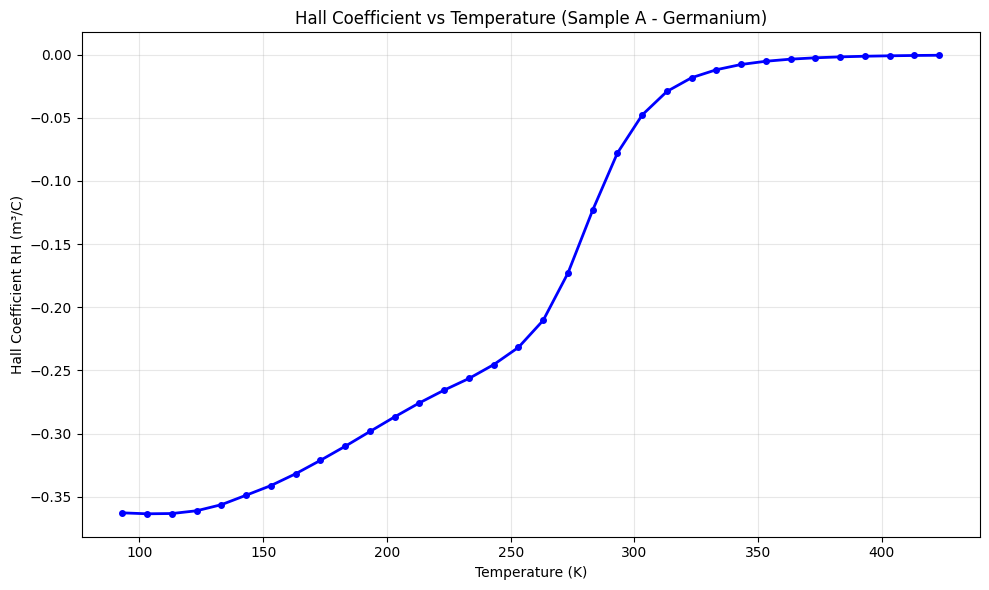

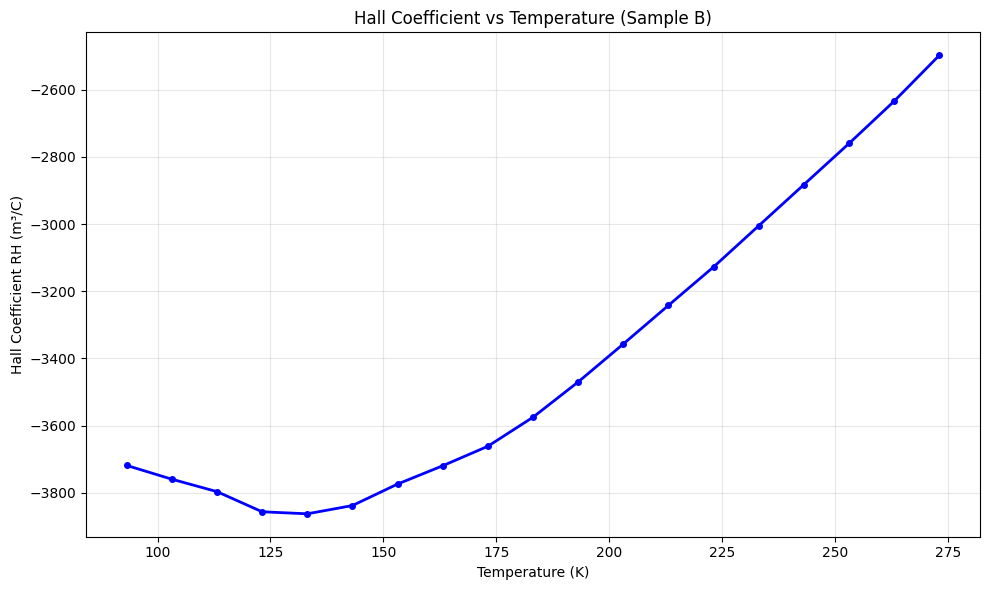

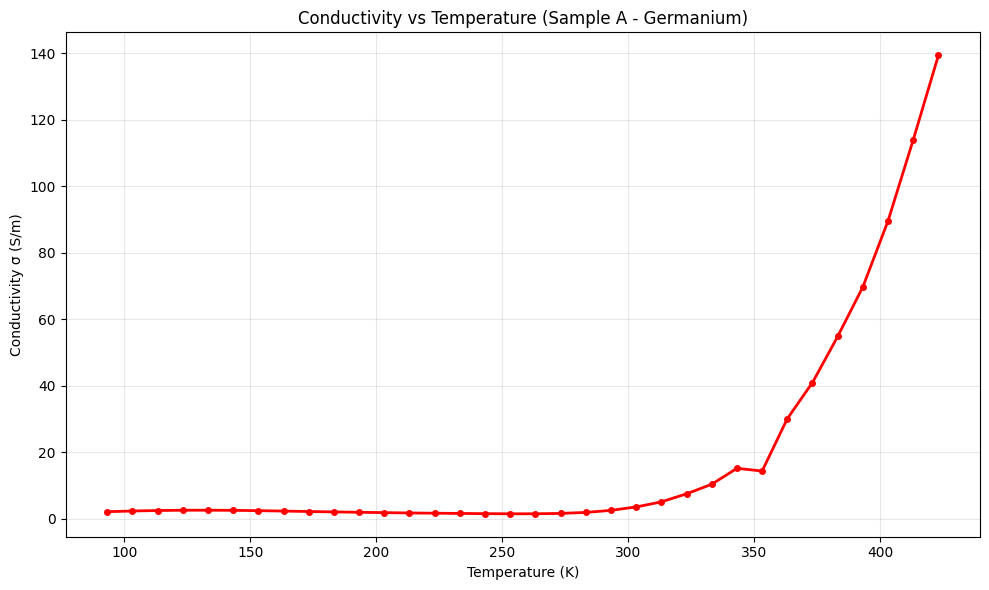

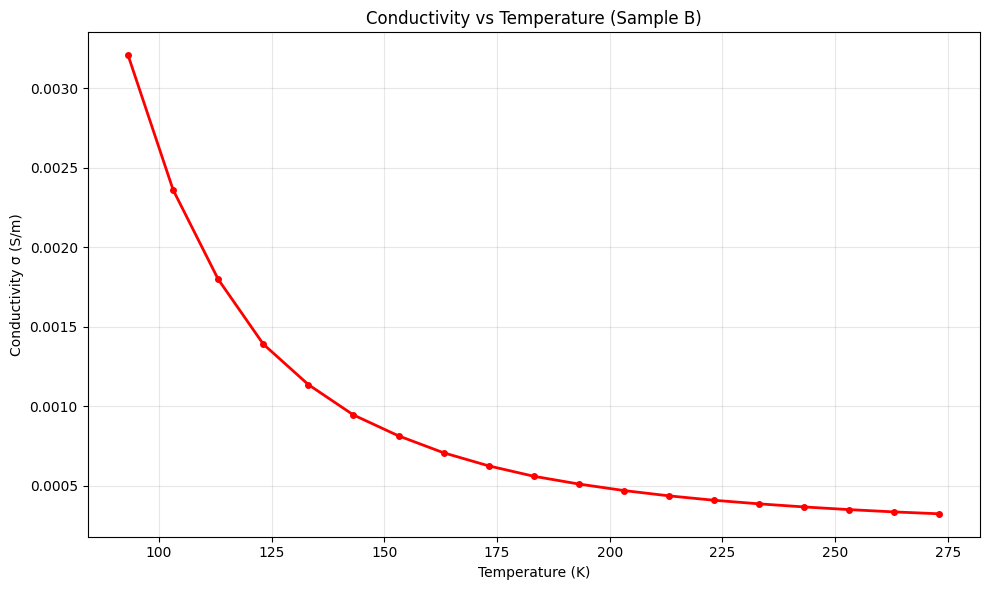

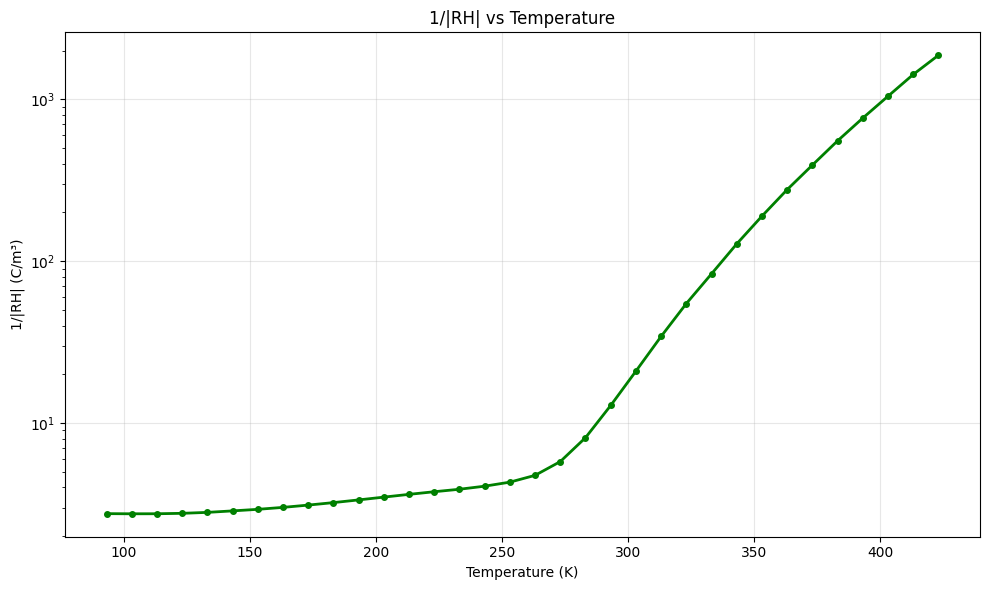

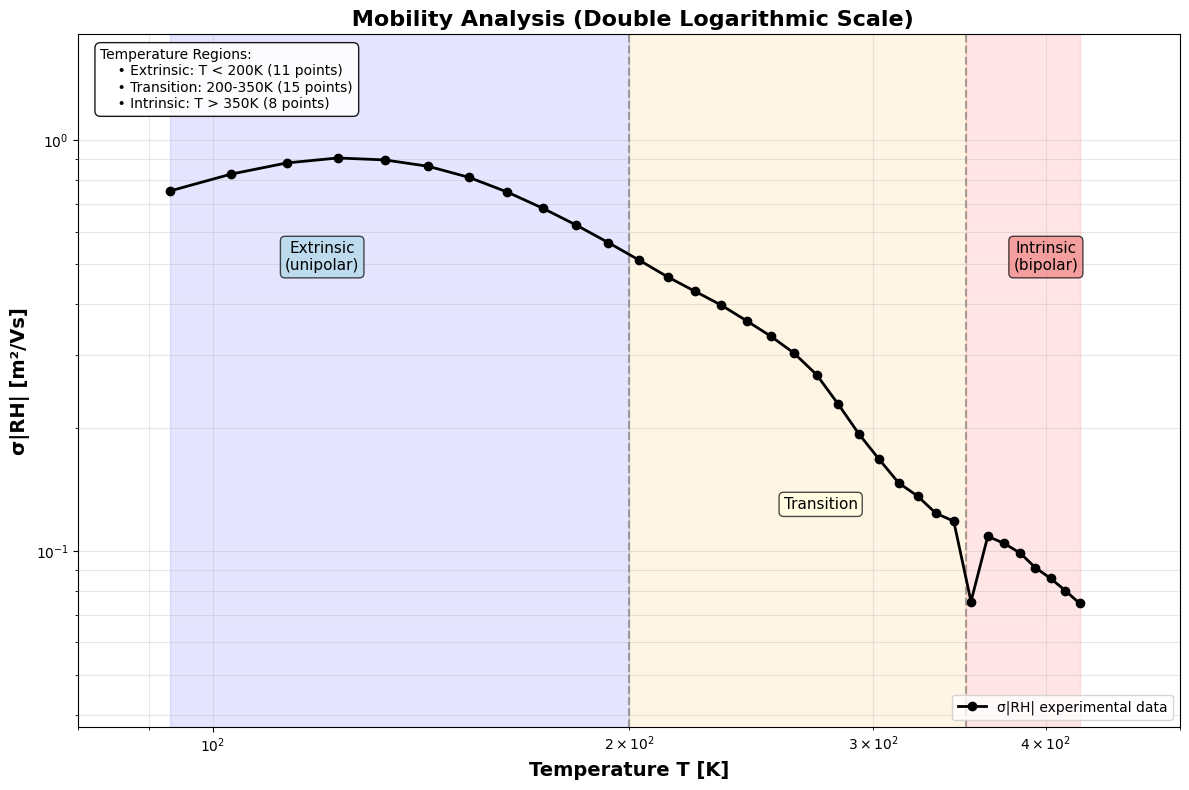


Task 3 Mobility Analysis Summary:
• Total data points: 34
• Temperature range: 93 - 423 K
• σ|RH| range: 7.46e-02 - 9.06e-01 m²/Vs
• Extrinsic region: 11 data points
• Transition region: 15 data points
• Intrinsic region: 8 data points


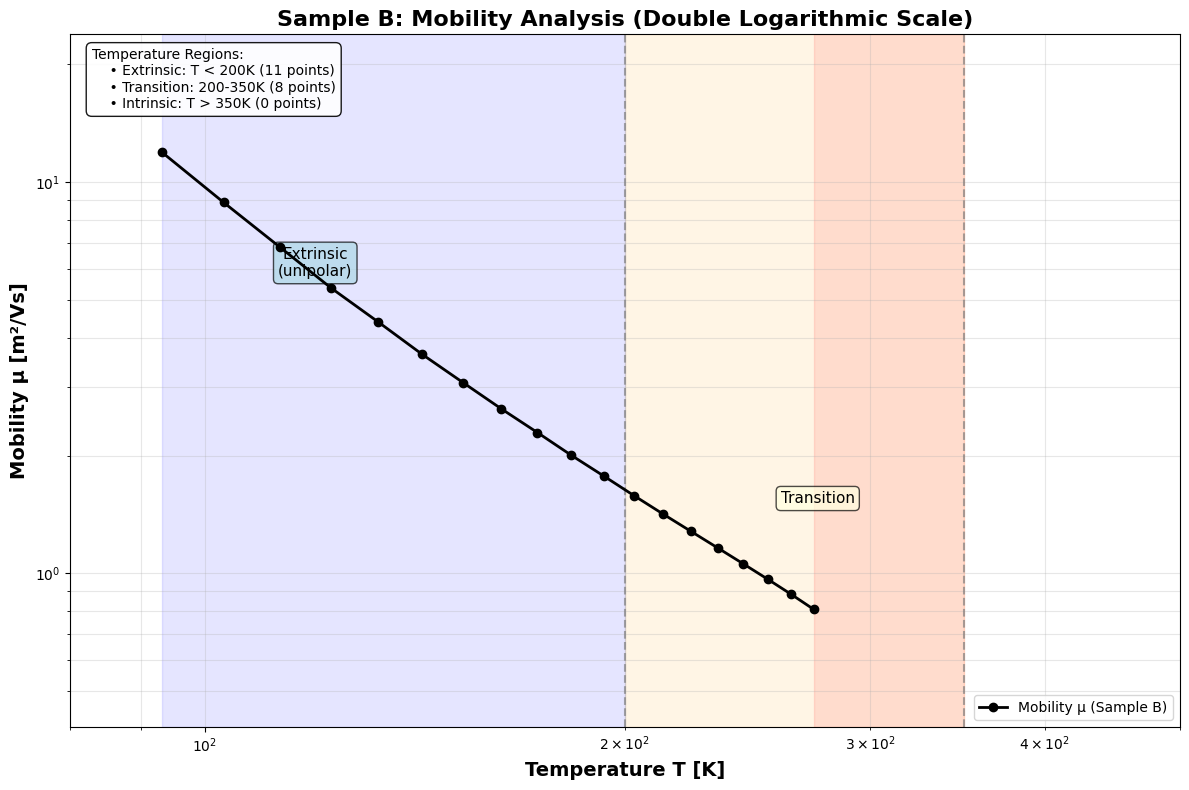


Sample B Mobility Analysis Summary:
• Total data points: 19
• Temperature range: 93 - 273 K
• Mobility range: 8.09e-01 - 1.19e+01 m²/Vs
• Extrinsic region: 11 data points
• Transition region: 8 data points
• Intrinsic region: 0 data points


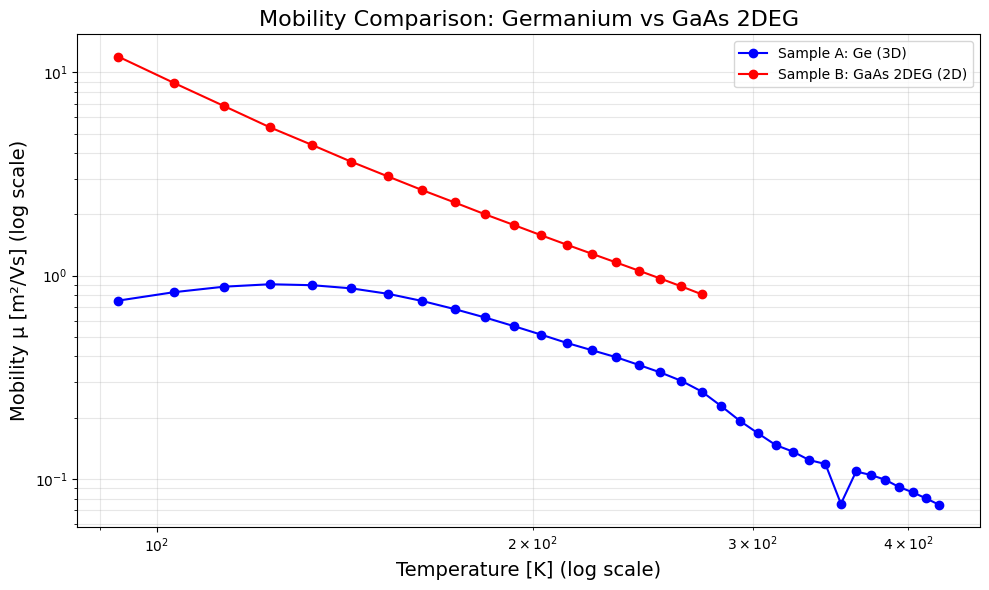

21    303.15
22    313.15
23    323.15
24    333.15
25    343.15
26    353.15
27    363.15
28    373.15
29    383.15
30    393.15
31    403.15
32    413.15
33    423.15
Name: T_K, dtype: float64
0     25.255025
1     24.691988
2     24.157806
3     23.650315
4     23.167563
5     22.707786
6     22.269380
7     21.850891
8     21.450989
9     21.068465
10    20.702209
11    20.351206
12    20.014522
13    19.691297
14    19.380742
15    19.082125
16    18.794771
17    18.518055
18    18.251396
19    17.994257
20    17.746135
21    17.506566
22    17.275114
23    17.051373
24    16.834966
25    16.625536
26    16.422752
27    16.226302
28    16.035895
29    15.851255
30    15.672124
31    15.498260
32    15.329434
33    15.165430
Name: inv_R_H_intrinsic, dtype: float64


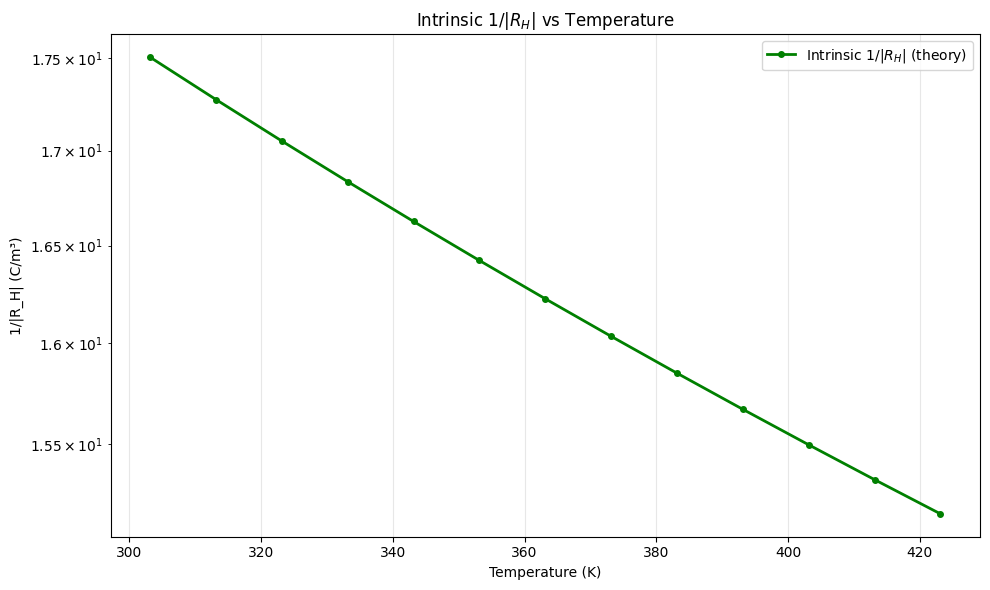


CHARGE CARRIER TYPE ANALYSIS
Average Hall coefficient in extrinsic region: -3.42e-01 m³/C
Average Hall voltage in extrinsic region: -1.71e-01 V

✓ RH < 0: Majority charge carriers are ELECTRONS (n-type)
✓ The semiconductor is n-doped (donor doping)

INTRINSIC CARRIER CONCENTRATION ANALYSIS
Temperature range for intrinsic region: 353.1 - 423.1 K
Number of data points in intrinsic region: 8

Intrinsic carrier concentrations:
T = 353.1 K: ni = 2.77e+14 cm⁻³
T = 363.1 K: ni = 4.09e+14 cm⁻³
T = 373.1 K: ni = 5.86e+14 cm⁻³
T = 383.1 K: ni = 8.38e+14 cm⁻³
T = 393.1 K: ni = 1.17e+15 cm⁻³
T = 403.1 K: ni = 1.62e+15 cm⁻³
T = 413.1 K: ni = 2.23e+15 cm⁻³
T = 423.1 K: ni = 2.96e+15 cm⁻³


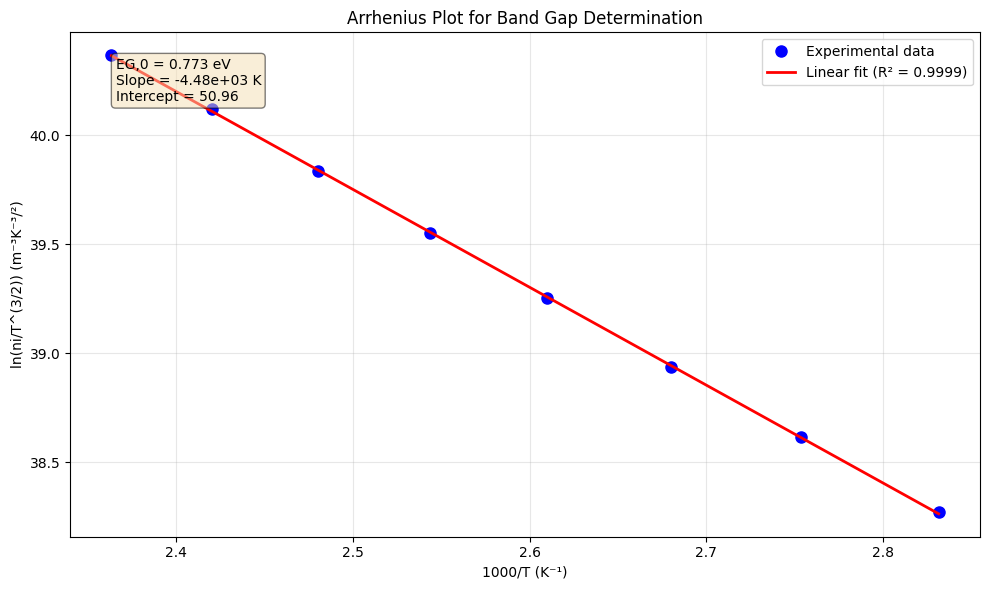


ARRHENIUS ANALYSIS RESULTS
Slope: -4.48e+03 K
Intercept: 50.96
R² value: 0.9999
Band gap EG,0: 0.773 eV
Literature EG,0 for Ge: ~0.74 eV

ni(300K) CALCULATION
Calculated ni(300K): 2.27e+13 cm⁻³
Literature value: 2.40e+13 cm⁻³
Relative difference: 5.3%

EG(300K) CALCULATION
EG,0 (extrapolated): 0.773 eV
Temperature coefficient α: 4e-04 eV/K
Calculated EG(300K): 0.653 eV
Literature value: 0.660 eV
Absolute difference: 7.1 meV

ANALYSIS COMPLETE
All plots have been saved as PNG files.

Sample A Final Data Summary:
              T_K        R_H  conductivity   inv_abs_RH  sigma_abs_RH  \
count   34.000000  34.000000     34.000000    34.000000     34.000000   
mean   258.150000  -0.177561     18.711590   203.511972      0.396233   
std     99.582462   0.148296     34.700376   439.779584      0.298806   
min     93.150000  -0.363570      1.439394     2.750502      0.074606   
25%    175.650000  -0.318455      1.861526     3.140895      0.119684   
50%    258.150000  -0.221110      2.450261  

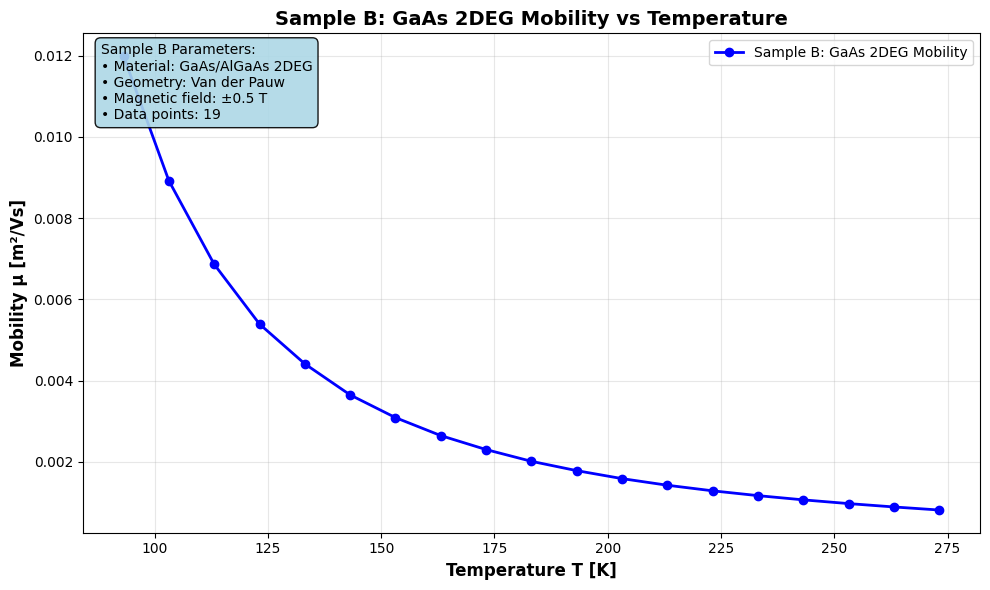


Sample B Raw Mobility Data:
• Temperature range: 93 - 273 K
• Mobility range: 8.13e-04 - 1.20e-02 m²/Vs

Task 3: Acoustic phonon fitting...


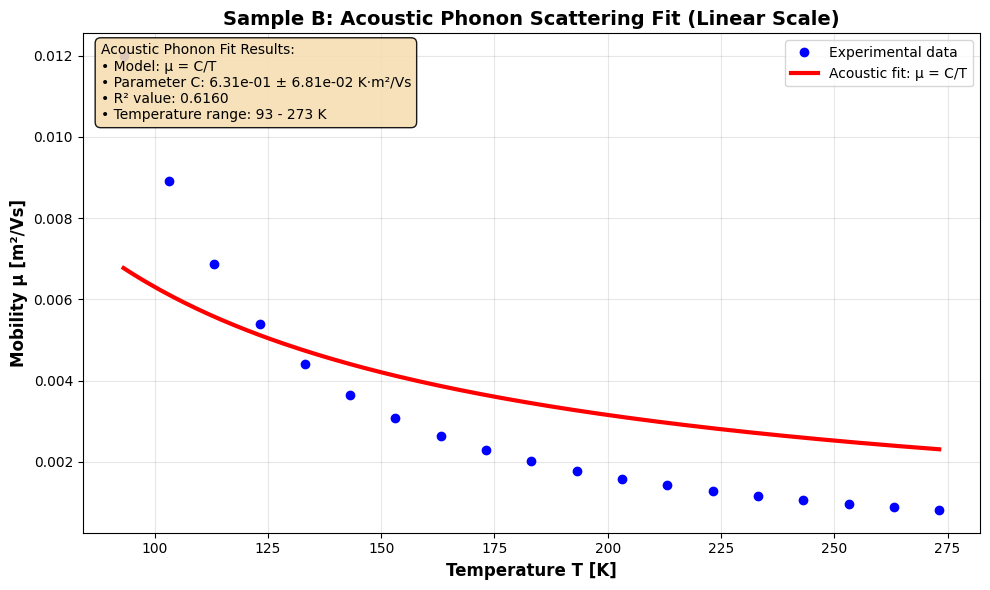


Acoustic Phonon Fit Results:
• C parameter: 6.31e-01 ± 6.81e-02 K·m²/Vs
• R² value: 0.6160

Task 4: Optical phonon fitting...


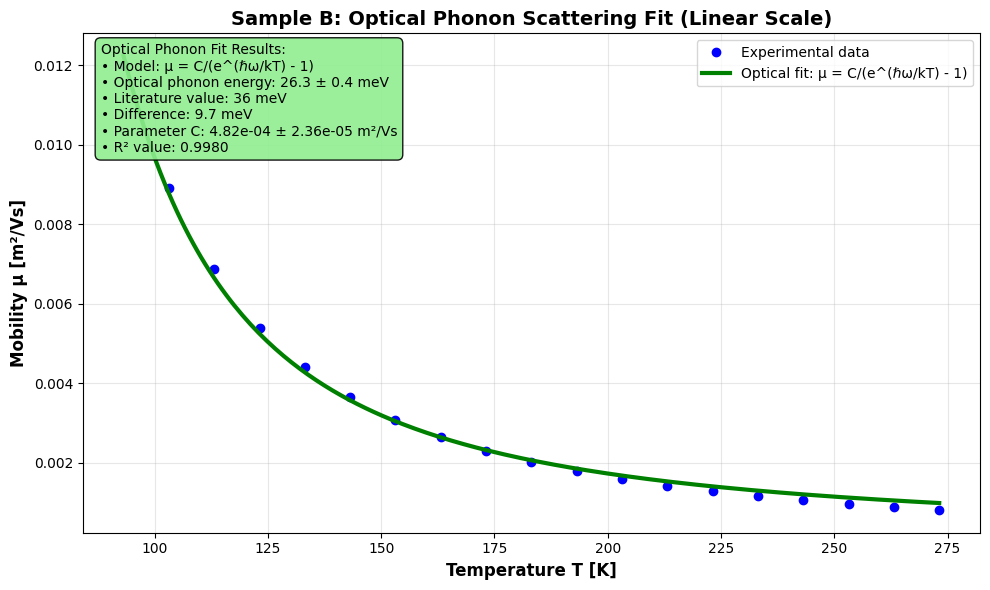


Optical Phonon Fit Results:
• Optical phonon energy: 26.26 ± 0.42 meV
• Literature value: 36 meV
• Absolute difference: 9.74 meV
• Relative difference: 27.1%
• R² value: 0.9980

SAMPLE B ANALYSIS COMPLETE

Sample B Acoustic Phonon Results:
C parameter: 6.31e-01
R² value: 0.6160

Sample B Optical Phonon Results:
Phonon energy: 26.26 meV
R² value: 0.9980


In [35]:

class HallEffectAnalyzer:
    def __init__(self, csv_file='Exp_4.csv'):
        """
        Initialize the Hall Effect Analyzer
        
        Parameters:
        csv_file (str): Path to the CSV data file
        """
        # Physical constants
        self.e = 1.602e-19  # Elementary charge [C]
        self.k_B = 1.381e-23  # Boltzmann constant [J/K]
        self.k_B_eV = 8.617e-5  # Boltzmann constant [eV/K]
        
        # Sample geometry parameters (adjust as needed)
        self.d = 1e-3  # Sample thickness [m]
        self.B = 0.5   # Magnetic field [T]
        self.l = 19e-3 # Sample length [m]
        self.b = 10e-3 # Sample width [m]
        
        # Literature values for comparison
        self.ni_literature_300K = 2.4e13  # [cm^-3] at 300K
        self.EG_literature_300K = 0.66    # [eV] at 300K
        self.alpha = 4e-4  # [eV/K] temperature coefficient
        
        # Load and process data
        self.df = self.load_and_process_data(csv_file)
        
    def load_and_process_data(self, csv_file):
        """Load CSV data and perform all calculations"""
        # Load the CSV file
        df = pd.read_csv(csv_file)
        
        # Rename columns for easier handling
        df.columns = ['T_C', 'I_sample_mA', 'U_Leit_V', 'I_sample_B_uA', 'U_B_cond_mV', 
                      'U_H_minus_mV', 'I_B_hall_minus_uA', 'U_B_hall_minus_mV', 
                      'U_H_plus_mV', 'I_B_hall_plus_uA', 'U_B_hall_plus_mV']
        
        # Convert temperature from Celsius to Kelvin
        df['T_K'] = df['T_C'] + 273.15
        
        # Convert units to SI
        df['I_sample_A'] = df['I_sample_mA'] * 1e-3  # mA to A
        df['U_H_minus_V'] = df['U_H_minus_mV'] * 1e-3  # mV to V
        df['U_H_plus_V'] = df['U_H_plus_mV'] * 1e-3   # mV to V
        df['I_sample_B'] = df['I_sample_B_uA'] * 1e-6  #uA to A
        df['I_B_hall_plus'] = df['I_B_hall_plus_uA'] * 1e-3  # uA to A
        df['I_B_hall_minus'] = df['I_B_hall_minus_uA'] * 1e-3  # uA to A
        df['U_B_cond'] = df['U_B_cond_mV'] * 1e-3  # mV to V
        df['U_B_hall_minus'] = df['U_B_hall_minus_mV'] * 1e-3  # mV to V
        df['U_B_hall_plus'] = df['U_B_hall_plus_mV'] * 1e-3  # mV to V
        
        # Calculate Hall voltage: UHall = [UH+(B=+0.5T) - UH-(B=-0.5T)]/2
        df['U_Hall_V'] = (df['U_H_plus_V'] - df['U_H_minus_V']) / 2
        df['U_Hall_V_B'] = (df['U_B_hall_plus'] - df['U_B_hall_minus']) / 2
        df['I_sample_B_Hall'] = 20*1e-6   #uA to A
        
        # Calculate Hall coefficient: RH = (UHall × d) / (I_sample × B)
        df['R_H'] = (df['U_Hall_V'] * self.d) / (df['I_sample_A'] * self.B)
        df['R_H_B'] = (df['U_Hall_V_B']) / (df['I_sample_B_Hall'] * self.B)
        
        # Calculate conductivity: σ = (I_sample × l) / (U_Leit × b × d)
        df['conductivity'] = (df['I_sample_A'] * self.l) / (df['U_Leit_V'] * self.b * self.d)
        df['conductivity_B'] = (df['I_sample_B'] * np.log(2)) / (df['U_B_cond'] * 3.1415)
        
        # Calculate mobility ratio: b = μn/μp = 1.2688 + 0.00097 × T
        df['mobility_ratio_b'] = 1.2688 + 0.00097 * df['T_K']
        ni_m_3 = self.ni_literature_300K * 1e6
        
        # Calculate derived quantities
        df['inv_abs_RH'] = 1 / np.abs(df['R_H'])  # Charge carrier density
        df['sigma_abs_RH'] = df['conductivity'] * np.abs(df['R_H'])  # Mobility analysis
        df['mobility_B'] = df['conductivity_B'] * np.abs(df['R_H_B'])  # Mobility analysis
        df['R_H_intrinsic'] = (1 - df['mobility_ratio_b']) / (self.e * ni_m_3 * (1 + df['mobility_ratio_b']))
        df['inv_R_H_intrinsic']=1 / np.abs(df['R_H_intrinsic'])
        
        # Remove rows with NaN values for calculations
        df = df.dropna(subset=['R_H', 'conductivity'])
        
        return df
    
    def plot_hall_coefficient_vs_temperature(self, save_fig=True):
        """Plot Hall coefficient vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['R_H'], 'bo-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Hall Coefficient RH (m³/C)')
        plt.title('Hall Coefficient vs Temperature (Sample A - Germanium)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('hall_coefficient_RH.png', dpi=300, bbox_inches='tight')
        plt.show()


    def plot_hall_coefficient_vs_temperature_sample_B(self, save_fig=True):
        """Plot Hall coefficient vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['R_H_B'], 'bo-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Hall Coefficient RH (m³/C)')
        plt.title('Hall Coefficient vs Temperature (Sample B)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('hall_coefficient_RH_B.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_conductivity_vs_temperature(self, save_fig=True):
        """Plot conductivity vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['conductivity'], 'ro-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Conductivity σ (S/m)')
        plt.title('Conductivity vs Temperature (Sample A - Germanium)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('conductivity_sigma.png', dpi=300, bbox_inches='tight')
        plt.show()

    
    def plot_conductivity_vs_temperature_sample_B(self, save_fig=True):
        """Plot conductivity vs temperature"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.df['T_K'], self.df['conductivity_B'], 'ro-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('Conductivity σ (S/m)')
        plt.title('Conductivity vs Temperature (Sample B)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('conductivity_sigma.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_charge_carrier_density(self, save_fig=True):
        """Plot 1/|RH| vs Temperature (log-linear)"""
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.df['T_K'], self.df['inv_abs_RH'], 'go-', linewidth=2, markersize=4)
        plt.xlabel('Temperature (K)')
        plt.ylabel('1/|RH| (C/m³)')
        plt.title('1/|RH| vs Temperature')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('charge_carrier_density.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_charge_carrier_density_intrinsic(self, save_fig=True):
        plt.figure(figsize=(10, 6))
        mask_intrinsic = self.df['T_K'] > 300
        plt.semilogy(self.df['T_K'][mask_intrinsic], self.df['inv_R_H_intrinsic'][mask_intrinsic], 
                     'go-', linewidth=2, markersize=4, label='Intrinsic $1/|R_H|$ (theory)')
        print(self.df['T_K'][mask_intrinsic])
        print(self.df['inv_R_H_intrinsic'])
        plt.xlabel('Temperature (K)')
        plt.ylabel('1/|R_H| (C/m³)')
        plt.title('Intrinsic $1/|R_H|$ vs Temperature')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        if save_fig:
            plt.savefig('charge_carrier_density_intrinsic.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_mobility_analysis(self, save_fig=True):
        """
        Task 3: σ|RH| vs T (log-log) with region markers (no fitting lines)
        Shows main experimental data with clear region identification
        """
        # Filter valid data for log-log plotting
        valid_data = self.df[(self.df['sigma_abs_RH'] > 0) & 
                            (np.isfinite(self.df['sigma_abs_RH'])) &
                            (self.df['T_K'] > 0)]
        
        if len(valid_data) == 0:
            print("No valid data for mobility analysis")
            return
        
        # Define temperature regions for reference
        extrinsic = valid_data[valid_data['T_K'] < 200]
        transition = valid_data[(valid_data['T_K'] >= 200) & (valid_data['T_K'] <= 350)]
        intrinsic = valid_data[valid_data['T_K'] > 350]
        
        # Create the main plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # MAIN DATA PLOT - Ensure this is visible
        ax.loglog(valid_data['T_K'], valid_data['sigma_abs_RH'],
                  'ko-', linewidth=2, markersize=6, markerfacecolor='black',
                  markeredgecolor='black', label='σ|RH| experimental data', zorder=5)
        
        # Region shading (very light)
        T_min, T_max = valid_data['T_K'].min(), valid_data['T_K'].max()
        ax.axvspan(T_min, 200, alpha=0.1, color='blue', zorder=1)
        ax.axvspan(200, 350, alpha=0.1, color='orange', zorder=1)
        ax.axvspan(350, T_max, alpha=0.1, color='red', zorder=1)
        
        # Vertical region separators
        ax.axvline(x=200, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
        ax.axvline(x=350, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Region labels
        y_mid = np.sqrt(valid_data['sigma_abs_RH'].min() * valid_data['sigma_abs_RH'].max())
        
        if len(extrinsic) > 0:
            ax.text(120, y_mid*2, 'Extrinsic\n(unipolar)', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
        if len(transition) > 0:
            ax.text(275, y_mid*0.5, 'Transition', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))
        
        if len(intrinsic) > 0:
            ax.text(400, y_mid*2, 'Intrinsic\n(bipolar)', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
        
        # Region information display
        region_info = f"""Temperature Regions:
    • Extrinsic: T < 200K ({len(extrinsic)} points)
    • Transition: 200-350K ({len(transition)} points)
    • Intrinsic: T > 350K ({len(intrinsic)} points)"""
        
        ax.text(0.02, 0.98, region_info, transform=ax.transAxes, fontsize=10,
               va='top', ha='left', bbox=dict(boxstyle='round,pad=0.4', 
               facecolor='white', alpha=0.9))
        
        # Formatting
        ax.set_xlabel('Temperature T [K]', fontsize=14, fontweight='bold')
        ax.set_ylabel('σ|RH| [m²/Vs]', fontsize=14, fontweight='bold')
        ax.set_title(' Mobility Analysis (Double Logarithmic Scale)', 
                    fontsize=16, fontweight='bold')
        
        # Set reasonable axis limits
        ax.set_xlim(80, 500)
        y_min = valid_data['sigma_abs_RH'].min() * 0.5
        y_max = valid_data['sigma_abs_RH'].max() * 2
        ax.set_ylim(y_min, y_max)
        
        # Grid and legend
        ax.grid(True, which="both", alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('task3_mobility_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print summary
        print(f"\nTask 3 Mobility Analysis Summary:")
        print(f"• Total data points: {len(valid_data)}")
        print(f"• Temperature range: {valid_data['T_K'].min():.0f} - {valid_data['T_K'].max():.0f} K")
        print(f"• σ|RH| range: {valid_data['sigma_abs_RH'].min():.2e} - {valid_data['sigma_abs_RH'].max():.2e} m²/Vs")
        print(f"• Extrinsic region: {len(extrinsic)} data points")
        print(f"• Transition region: {len(transition)} data points") 
        print(f"• Intrinsic region: {len(intrinsic)} data points")
        
        return None


    def plot_mobility_analysis_sampleB(self, save_fig=True):
        """
        Plot Sample B (GaAs 2DEG) mobility μ vs T (log-log) with region markers (no fitting lines).
        Shows main experimental data with clear region identification.
        """
        # Filter valid data for log-log plotting
        valid_data = self.df[(self.df['mobility_B'] > 0) & 
                            (np.isfinite(self.df['mobility_B'])) &
                            (self.df['T_K'] > 0)]
        
        if len(valid_data) == 0:
            print("No valid data for Sample B mobility analysis")
            return
        
        # Define temperature regions for reference
        extrinsic = valid_data[valid_data['T_K'] < 200]
        transition = valid_data[(valid_data['T_K'] >= 200) & (valid_data['T_K'] <= 350)]
        intrinsic = valid_data[valid_data['T_K'] > 350]
        
        # Create the main plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # MAIN DATA PLOT - Ensure this is visible
        ax.loglog(valid_data['T_K'], valid_data['mobility_B'],
                  'ko-', linewidth=2, markersize=6, markerfacecolor='black',
                  markeredgecolor='black', label='Mobility μ (Sample B)', zorder=5)
        
        # Region shading (very light)
        T_min, T_max = valid_data['T_K'].min(), valid_data['T_K'].max()
        ax.axvspan(T_min, 200, alpha=0.1, color='blue', zorder=1)
        ax.axvspan(200, 350, alpha=0.1, color='orange', zorder=1)
        ax.axvspan(350, T_max, alpha=0.1, color='red', zorder=1)
        
        # Vertical region separators
        ax.axvline(x=200, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
        ax.axvline(x=350, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Region labels
        y_mid = np.sqrt(valid_data['mobility_B'].min() * valid_data['mobility_B'].max())
        
        if len(extrinsic) > 0:
            ax.text(120, y_mid*2, 'Extrinsic\n(unipolar)', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
        
        if len(transition) > 0:
            ax.text(275, y_mid*0.5, 'Transition', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7))
        
        if len(intrinsic) > 0:
            ax.text(400, y_mid*2, 'Intrinsic\n(bipolar)', ha='center', va='center', 
                    fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
        
        # Region information display
        region_info = f"""Temperature Regions:
    • Extrinsic: T < 200K ({len(extrinsic)} points)
    • Transition: 200-350K ({len(transition)} points)
    • Intrinsic: T > 350K ({len(intrinsic)} points)"""
        
        ax.text(0.02, 0.98, region_info, transform=ax.transAxes, fontsize=10,
               va='top', ha='left', bbox=dict(boxstyle='round,pad=0.4', 
               facecolor='white', alpha=0.9))
        
        # Formatting
        ax.set_xlabel('Temperature T [K]', fontsize=14, fontweight='bold')
        ax.set_ylabel('Mobility μ [m²/Vs]', fontsize=14, fontweight='bold')
        ax.set_title('Sample B: Mobility Analysis (Double Logarithmic Scale)', 
                    fontsize=16, fontweight='bold')
        
        # Set reasonable axis limits
        ax.set_xlim(80, 500)
        y_min = valid_data['mobility_B'].min() * 0.5
        y_max = valid_data['mobility_B'].max() * 2
        ax.set_ylim(y_min, y_max)
        
        # Grid and legend
        ax.grid(True, which="both", alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('sampleB_mobility_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print summary
        print(f"\nSample B Mobility Analysis Summary:")
        print(f"• Total data points: {len(valid_data)}")
        print(f"• Temperature range: {valid_data['T_K'].min():.0f} - {valid_data['T_K'].max():.0f} K")
        print(f"• Mobility range: {valid_data['mobility_B'].min():.2e} - {valid_data['mobility_B'].max():.2e} m²/Vs")
        print(f"• Extrinsic region: {len(extrinsic)} data points")
        print(f"• Transition region: {len(transition)} data points") 
        print(f"• Intrinsic region: {len(intrinsic)} data points")
        
        return None

    def plot_mobility_comparison(self, save_fig=True):
        """
        Plot Sample A (Germanium) and Sample B (GaAs 2DEG) mobilities on the same graph.
        Both Y-axis and X-axis are logarithmic.
        """
        plt.figure(figsize=(10, 6))
        # Plot Sample A mobility (3D, platelet)
        plt.loglog(self.df['T_K'], self.df['sigma_abs_RH'], 'bo-', label='Sample A: Ge (3D)')
        # Plot Sample B mobility (2DEG, Van der Pauw)
        plt.loglog(self.df['T_K'], self.df['mobility_B'], 'ro-', label='Sample B: GaAs 2DEG (2D)')
        plt.xlabel('Temperature [K] (log scale)', fontsize=14)
        plt.ylabel('Mobility μ [m²/Vs] (log scale)', fontsize=14)
        plt.title('Mobility Comparison: Germanium vs GaAs 2DEG', fontsize=16)
        plt.legend()
        plt.grid(True, which='both', alpha=0.3)
        plt.tight_layout()
        if save_fig:
            plt.savefig('mobility_comparison_A_vs_B.png', dpi=300, bbox_inches='tight')
        plt.show()

    
    
    def determine_charge_carrier_type(self):
        """Determine charge carrier type from Hall coefficient sign"""
        # Analyze extrinsic region (low temperature)
        extrinsic_data = self.df[self.df['T_K'] < 200]
        
        if len(extrinsic_data) > 0:
            avg_RH = extrinsic_data['R_H'].mean()
            avg_hall_voltage = extrinsic_data['U_Hall_V'].mean()
            
            print("\n" + "="*60)
            print("CHARGE CARRIER TYPE ANALYSIS")
            print("="*60)
            print(f"Average Hall coefficient in extrinsic region: {avg_RH:.2e} m³/C")
            print(f"Average Hall voltage in extrinsic region: {avg_hall_voltage:.2e} V")
            
            if avg_RH > 0:
                print("\n✓ RH > 0: Majority charge carriers are HOLES (p-type)")
                print("✓ The semiconductor is p-doped (acceptor doping)")
                carrier_type = "p-type"
            else:
                print("\n✓ RH < 0: Majority charge carriers are ELECTRONS (n-type)")
                print("✓ The semiconductor is n-doped (donor doping)")
                carrier_type = "n-type"
            
            return carrier_type, avg_RH
        else:
            print("Not enough data in extrinsic region for carrier type determination")
            return "unknown", 0
    
    def calculate_intrinsic_concentration(self):
        """Calculate intrinsic carrier concentration from RH in intrinsic region"""
        # Select intrinsic region (high temperature)
        intrinsic_data = self.df[self.df['T_K'] > 350].copy()
        
        if len(intrinsic_data) > 0:
            # Calculate ni using Equation 55: ni = (1-b)/((1+b)*e*RH)
            factor = (1 - intrinsic_data['mobility_ratio_b']) / (1 + intrinsic_data['mobility_ratio_b'])
            intrinsic_data['ni_m3'] = factor / (self.e * intrinsic_data['R_H'])
            intrinsic_data['ni_cm3'] = intrinsic_data['ni_m3'] / 1e6
            
            print("\n" + "="*60)
            print("INTRINSIC CARRIER CONCENTRATION ANALYSIS")
            print("="*60)
            print(f"Temperature range for intrinsic region: {intrinsic_data['T_K'].min():.1f} - {intrinsic_data['T_K'].max():.1f} K")
            print(f"Number of data points in intrinsic region: {len(intrinsic_data)}")
            
            if len(intrinsic_data) > 0:
                print("\nIntrinsic carrier concentrations:")
                for _, row in intrinsic_data.iterrows():
                    print(f"T = {row['T_K']:.1f} K: ni = {row['ni_cm3']:.2e} cm⁻³")
            
            return intrinsic_data
        else:
            print("No data points in intrinsic region (T > 350K)")
            return pd.DataFrame()
    
    def arrhenius_analysis(self, ni_data):
        """Perform Arrhenius analysis to determine band gap"""
        if len(ni_data) < 3:
            print("Not enough data points for Arrhenius analysis")
            return None, None, None
        
        T = ni_data['T_K'].values
        ni = ni_data['ni_m3'].values
        
        # Calculate ln(ni/T^(3/2))
        ln_ni_T32 = np.log(ni / (T**(3/2)))
        
        # Calculate 1/T
        inv_T = 1 / T
        
        # Linear fit: ln(ni/T^(3/2)) = ln(A) - EG,0/(2*k_B*T)
        slope, intercept, r_value, p_value, std_err = stats.linregress(inv_T, ln_ni_T32)
        
        # Calculate EG,0 from slope
        EG_0 = -slope * 2 * self.k_B_eV
        
        # Create Arrhenius plot
        plt.figure(figsize=(10, 6))
        plt.plot(inv_T * 1000, ln_ni_T32, 'bo', markersize=8, label='Experimental data')
        
        # Plot fit line
        inv_T_fit = np.linspace(inv_T.min(), inv_T.max(), 100)
        ln_ni_T32_fit = slope * inv_T_fit + intercept
        plt.plot(inv_T_fit * 1000, ln_ni_T32_fit, 'r-', linewidth=2,
                 label=f'Linear fit (R² = {r_value**2:.4f})')
        
        plt.xlabel('1000/T (K⁻¹)')
        plt.ylabel('ln(ni/T^(3/2)) (m⁻³K⁻³/²)')
        plt.title('Arrhenius Plot for Band Gap Determination')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add text box with results
        textstr = f'EG,0 = {EG_0:.3f} eV\nSlope = {slope:.2e} K\nIntercept = {intercept:.2f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.savefig('arrhenius_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n" + "="*60)
        print("ARRHENIUS ANALYSIS RESULTS")
        print("="*60)
        print(f"Slope: {slope:.2e} K")
        print(f"Intercept: {intercept:.2f}")
        print(f"R² value: {r_value**2:.4f}")
        print(f"Band gap EG,0: {EG_0:.3f} eV")
        print(f"Literature EG,0 for Ge: ~0.74 eV")
        
        return EG_0, intercept, slope
    
    def calculate_ni_300K(self, EG_0, intercept):
        """Calculate ni(300K) and compare with literature"""
        if EG_0 is None:
            return None
        
        T_300 = 300  # K
        ln_ni_T32_300 = intercept - EG_0 / (2 * self.k_B_eV * T_300)
        ni_300K = np.exp(ln_ni_T32_300) * (T_300**(3/2))
        ni_300K_cm3 = ni_300K / 1e6
        
        print("\n" + "="*60)
        print("ni(300K) CALCULATION")
        print("="*60)
        print(f"Calculated ni(300K): {ni_300K_cm3:.2e} cm⁻³")
        print(f"Literature value: {self.ni_literature_300K:.2e} cm⁻³")
        print(f"Relative difference: {abs(ni_300K_cm3 - self.ni_literature_300K)/self.ni_literature_300K*100:.1f}%")
        
        return ni_300K_cm3
    
    def calculate_EG_300K(self, EG_0):
        """Calculate EG(300K) using temperature dependence"""
        if EG_0 is None:
            return None
        
        T_300 = 300  # K
        EG_300K = EG_0 - self.alpha * T_300
        
        print("\n" + "="*60)
        print("EG(300K) CALCULATION")
        print("="*60)
        print(f"EG,0 (extrapolated): {EG_0:.3f} eV")
        print(f"Temperature coefficient α: {self.alpha:.0e} eV/K")
        print(f"Calculated EG(300K): {EG_300K:.3f} eV")
        print(f"Literature value: {self.EG_literature_300K:.3f} eV")
        print(f"Absolute difference: {abs(EG_300K - self.EG_literature_300K)*1000:.1f} meV")
        
        return EG_300K
    
    
    def run_complete_analysis(self):
        """Run the complete Hall effect analysis"""
        print("=" * 80)
        print("COMPLETE HALL EFFECT AND CONDUCTIVITY ANALYSIS")
        print("Sample A - Germanium")
        print("=" * 80)
        
        print(f"\nData Summary:")
        print(f"Temperature range: {self.df['T_C'].min()}°C to {self.df['T_C'].max()}°C")
        print(f"Number of data points: {len(self.df)}")
        
        # Generate all plots
        print("\nGenerating plots...")
        self.plot_hall_coefficient_vs_temperature()
        self.plot_hall_coefficient_vs_temperature_sample_B()
        self.plot_conductivity_vs_temperature()
        self.plot_conductivity_vs_temperature_sample_B()
        self.plot_charge_carrier_density()
        self.plot_mobility_analysis()
        self.plot_mobility_analysis_sampleB()
        self.plot_mobility_comparison()
        self.plot_charge_carrier_density_intrinsic()
        
        # Determine charge carrier type
        carrier_type, avg_RH = self.determine_charge_carrier_type()
        
        # Calculate intrinsic carrier concentration
        ni_data = self.calculate_intrinsic_concentration()
        
        if len(ni_data) > 0:
            # Perform Arrhenius analysis
            EG_0, intercept, slope = self.arrhenius_analysis(ni_data)
            
            if EG_0 is not None:
                # Calculate ni(300K)
                ni_300K = self.calculate_ni_300K(EG_0, intercept)
                
                # Calculate EG(300K)
                EG_300K = self.calculate_EG_300K(EG_0)
        
        
        print("\n" + "=" * 80)
        print("ANALYSIS COMPLETE")
        print("All plots have been saved as PNG files.")
        print("=" * 80)
        
        return self.df


class SampleBAnalyzer:
    def __init__(self, csv_file='Exp_4.csv'):
        """Sample B: GaAs 2DEG Analysis with Van der Pauw geometry"""
        # Physical constants
        self.e = 1.602e-19
        self.k_B_meV = 0.08617  # meV/K
        self.B = 0.5  # Tesla
        #self.I_fixed = 20e-6  # Fixed current [A]
        
        # Literature values
        self.hbar_omega_literature = 36  # meV
        
        # Load and process data
        self.df = self.load_and_process_sample_B(csv_file)
    
    def load_and_process_sample_B(self, csv_file):
        """Process Sample B data with Van der Pauw formulas"""
        df = pd.read_csv(csv_file)
        
        df.columns = ['T_C', 'I_sample_mA', 'U_Leit_V', 'I_sample_B_uA', 'U_B_cond_mV', 
                      'U_H_minus_mV', 'I_B_hall_minus_uA', 'U_B_hall_minus_mV', 
                      'U_H_plus_mV', 'I_B_hall_plus_uA', 'U_B_hall_plus_mV']
        
        # Temperature conversion
        df['T_K'] = df['T_C'] + 273.15

          # Convert units to SI
        df['I_sample_B'] = df['I_sample_B_uA'] * 1e-6  #uA to A
        df['I_B_hall_plus'] = df['I_B_hall_plus_uA'] * 1e-3  # uA to A
        df['I_B_hall_minus'] = df['I_B_hall_minus_uA'] * 1e-3
            
            # uA to A
        df['U_B_cond'] = df['U_B_cond_mV'] * 1e-3  # mV to V
        df['U_B_hall_minus'] = df['U_B_hall_minus_mV'] * 1e-3  # mV to V
        df['U_B_hall_plus'] = df['U_B_hall_plus_mV'] * 1e-3  # mV to V
        
        # Calculate Hall voltage: UHall = [UH+(B=+0.5T) - UH-(B=-0.5T)]/2
        df['U_Hall_V'] = (df['U_B_hall_plus'] - df['U_B_hall_minus']) / 2
        df['I_sample_B_Hall'] = 19.9 * 1e-3   #uA to A
        
        # Calculate Hall coefficient: RH = (UHall × d) / (I_sample × B)
        df['R_H'] = (df['U_Hall_V']) / (df['I_sample_B_Hall'] * self.B)
        
        # Calculate conductivity: σ = (I_sample × l) / (U_Leit × b × d)
        df['conductivity'] = (df['I_sample_B'] * np.log(2)) / (df['U_B_cond'] * 3.1415)
        
        # Calculate derived quantities
        df['mobility'] = df['conductivity'] * np.abs(df['R_H'])  # Mobility analysis
        
        
        # Remove rows with NaN values for calculations
        df = df.dropna(subset=['R_H', 'conductivity'])

        return df
    
    def plot_sample_B_raw_mobility(self, save_fig=True):
        """Task 1: Raw mobility plot for Sample B (no fits)"""
        plt.figure(figsize=(10, 6))
        
        plt.plot(self.df['T_K'], self.df['mobility'], 'bo-', linewidth=2, 
                markersize=6, label='Sample B: GaAs 2DEG Mobility')
        
        plt.xlabel('Temperature T [K]', fontsize=12, fontweight='bold')
        plt.ylabel('Mobility μ [m²/Vs]', fontsize=12, fontweight='bold')
        plt.title('Sample B: GaAs 2DEG Mobility vs Temperature', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Sample info
        info_text = f"""Sample B Parameters:
• Material: GaAs/AlGaAs 2DEG
• Geometry: Van der Pauw
• Magnetic field: ±{self.B} T
• Data points: {len(self.df)}"""
        
        plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=10,
                va='top', ha='left', bbox=dict(boxstyle='round,pad=0.4', 
                facecolor='lightblue', alpha=0.9))
        
        plt.tight_layout()
        
        if save_fig:
            plt.savefig('sampleB_mobility_raw.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nSample B Raw Mobility Data:")
        print(f"• Temperature range: {self.df['T_K'].min():.0f} - {self.df['T_K'].max():.0f} K")
        print(f"• Mobility range: {self.df['mobility'].min():.2e} - {self.df['mobility'].max():.2e} m²/Vs")
    
    def fit_acoustic_phonon(self, save_fig=True):
        """Task 2: Acoustic phonon fitting (Linear scale)"""
        T_data_ori = self.df['T_K'].values
        mobility_data = self.df['mobility'].values
        
        # Acoustic model: μ = C/T
        def acoustic_model(T, C_ac):
            return C_ac / T
        
        try:
            # Fit acoustic model
            T_data = T_data_ori 
            #mask for choosing range
            popt_ac, pcov_ac = curve_fit(acoustic_model, T_data, mobility_data, 
                                        p0=[np.mean(mobility_data * T_data)])
            
            C_ac_fit = popt_ac[0]
            C_ac_error = np.sqrt(np.diag(pcov_ac))[0]
            
            # Calculate R²
            mobility_fit = acoustic_model(T_data, C_ac_fit)
            ss_res = np.sum((mobility_data - mobility_fit)**2)
            ss_tot = np.sum((mobility_data - np.mean(mobility_data))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Plot on LINEAR scale
            plt.figure(figsize=(10, 6))
            
            # Experimental data
            plt.plot(T_data, mobility_data, 'bo', markersize=6, label='Experimental data')
            
            # Fit curve
            T_fit = np.linspace(T_data.min(), T_data.max(), 200)
            mobility_acoustic_fit = acoustic_model(T_fit, C_ac_fit)
            plt.plot(T_fit, mobility_acoustic_fit, 'r-', linewidth=3,
                    label=f'Acoustic fit: μ = C/T')
            
            plt.xlabel('Temperature T [K]', fontsize=12, fontweight='bold')
            plt.ylabel('Mobility μ [m²/Vs]', fontsize=12, fontweight='bold')
            plt.title('Sample B: Acoustic Phonon Scattering Fit (Linear Scale)', 
                     fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            # Results annotation
            results_text = f"""Acoustic Phonon Fit Results:
• Model: μ = C/T
• Parameter C: {C_ac_fit:.2e} ± {C_ac_error:.2e} K·m²/Vs
• R² value: {r_squared:.4f}
• Temperature range: {T_data.min():.0f} - {T_data.max():.0f} K"""
            
            plt.text(0.02, 0.98, results_text, transform=plt.gca().transAxes, fontsize=10,
                    va='top', ha='left', bbox=dict(boxstyle='round,pad=0.4', 
                    facecolor='wheat', alpha=0.9))
            
            plt.tight_layout()
            
            if save_fig:
                plt.savefig('sampleB_mobility_acoustic_fit.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"\nAcoustic Phonon Fit Results:")
            print(f"• C parameter: {C_ac_fit:.2e} ± {C_ac_error:.2e} K·m²/Vs")
            print(f"• R² value: {r_squared:.4f}")
            
            return {'C_ac': C_ac_fit, 'C_ac_error': C_ac_error, 'r_squared': r_squared}
            
        except Exception as e:
            print(f"Acoustic phonon fitting failed: {e}")
            return None
    
    def fit_optical_phonon(self, save_fig=True):
        """Task 3: Optical phonon fitting (Linear scale)"""
        T_data = self.df['T_K'].values
        mobility_data = self.df['mobility'].values
        
        # Optical model: μ = C/(e^(ℏω/kBT) - 1)
        def optical_model(T, C_op, hbar_omega):
            exp_term = np.exp(hbar_omega / (self.k_B_meV * T))
            return C_op * (exp_term - 1)
        
        try:
            # Initial guesses
            C_op_guess = 1e-3
            hbar_omega_guess = 36  # Literature value
            
            # Fit optical model
            #mask for choosing range
            
            popt_op, pcov_op = curve_fit(optical_model, T_data, mobility_data,
                                        p0=[C_op_guess, hbar_omega_guess],
                                        bounds=([0, 20], [np.inf, 60]))
            
            C_op_fit, hbar_omega_fit = popt_op
            param_errors = np.sqrt(np.diag(pcov_op))
            C_op_error, hbar_omega_error = param_errors
            
            # Calculate R²
            mobility_fit = optical_model(T_data, *popt_op)
            ss_res = np.sum((mobility_data - mobility_fit)**2)
            ss_tot = np.sum((mobility_data - np.mean(mobility_data))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Plot on LINEAR scale
            plt.figure(figsize=(10, 6))
            
            # Experimental data
            plt.plot(T_data, mobility_data, 'bo', markersize=6, label='Experimental data')
            
            # Fit curve
            T_fit = np.linspace(T_data.min(), T_data.max(), 200)
            mobility_optical_fit = optical_model(T_fit, C_op_fit, hbar_omega_fit)
            plt.plot(T_fit, mobility_optical_fit, 'g-', linewidth=3,
                    label=f'Optical fit: μ = C/(e^(ℏω/kT) - 1)')
            
            plt.xlabel('Temperature T [K]', fontsize=12, fontweight='bold')
            plt.ylabel('Mobility μ [m²/Vs]', fontsize=12, fontweight='bold')
            plt.title('Sample B: Optical Phonon Scattering Fit (Linear Scale)', 
                     fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            # **KEY RESULTS: Optical phonon energy**
            results_text = f"""Optical Phonon Fit Results:
• Model: μ = C/(e^(ℏω/kT) - 1)
• Optical phonon energy: {hbar_omega_fit:.1f} ± {hbar_omega_error:.1f} meV
• Literature value: {self.hbar_omega_literature} meV
• Difference: {abs(hbar_omega_fit - self.hbar_omega_literature):.1f} meV
• Parameter C: {C_op_fit:.2e} ± {C_op_error:.2e} m²/Vs
• R² value: {r_squared:.4f}"""
            
            plt.text(0.02, 0.98, results_text, transform=plt.gca().transAxes, fontsize=10,
                    va='top', ha='left', bbox=dict(boxstyle='round,pad=0.4', 
                    facecolor='lightgreen', alpha=0.9))
            
            plt.tight_layout()
            
            if save_fig:
                plt.savefig('sampleB_mobility_optical_fit.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"\nOptical Phonon Fit Results:")
            print(f"• Optical phonon energy: {hbar_omega_fit:.2f} ± {hbar_omega_error:.2f} meV")
            print(f"• Literature value: {self.hbar_omega_literature} meV")
            print(f"• Absolute difference: {abs(hbar_omega_fit - self.hbar_omega_literature):.2f} meV")
            print(f"• Relative difference: {abs(hbar_omega_fit - self.hbar_omega_literature)/self.hbar_omega_literature*100:.1f}%")
            print(f"• R² value: {r_squared:.4f}")
            
            return {
                'hbar_omega': hbar_omega_fit,
                'hbar_omega_error': hbar_omega_error,
                'C_op': C_op_fit,
                'C_op_error': C_op_error,
                'r_squared': r_squared
            }
            
        except Exception as e:
            print(f"Optical phonon fitting failed: {e}")
            return None

    def run_complete_sample_B_analysis(self):
        """Run all Sample B tasks"""
        print("=" * 60)
        print("SAMPLE B ANALYSIS: GaAs 2DEG (Van der Pauw Geometry)")
        print("=" * 60)
        
        print(f"\nSample B Data Summary:")
        print(f"• Temperature range: {self.df['T_K'].min():.0f} - {self.df['T_K'].max():.0f} K")
        print(f"• Valid data points: {len(self.df)}")
        #print(f"• Fixed current: {self.I_fixed*1e6:.0f} μA")
        
        # Task sequence
        print("\nTask 1: Raw mobility plot...")
        self.plot_sample_B_raw_mobility()
                
        print("\nTask 3: Acoustic phonon fitting...")
        acoustic_results = self.fit_acoustic_phonon()
        
        print("\nTask 4: Optical phonon fitting...")
        optical_results = self.fit_optical_phonon()
        
        print("\n" + "=" * 60)
        print("SAMPLE B ANALYSIS COMPLETE")
        print("=" * 60)
        
        return acoustic_results, optical_results




def main():
    """Main function to run both Sample A and Sample B analysis"""
    try:
        # ===== SAMPLE A ANALYSIS =====
        print("Starting Sample A (Germanium) Analysis...")
        analyzer = HallEffectAnalyzer('Exp_4.csv')
        results = analyzer.run_complete_analysis()
        
        # Display Sample A summary statistics
        print("\nSample A Final Data Summary:")
        summary_cols = ['T_K', 'R_H', 'conductivity', 'inv_abs_RH', 'sigma_abs_RH', 'conductivity_B', 'mobility_B']
        print(results[summary_cols].describe())
        
        # ===== SAMPLE B ANALYSIS =====
        print("\n" + "="*60)
        print("Starting Sample B (GaAs 2DEG) Analysis...")
        sample_b_analyzer = SampleBAnalyzer('Exp_4.csv')
        acoustic_results, optical_results = sample_b_analyzer.run_complete_sample_B_analysis()

        # Display Sample B results if available
        if acoustic_results:
            print(f"\nSample B Acoustic Phonon Results:")
            print(f"C parameter: {acoustic_results['C_ac']:.2e}")
            print(f"R² value: {acoustic_results['r_squared']:.4f}")
        
        if optical_results:
            print(f"\nSample B Optical Phonon Results:")
            print(f"Phonon energy: {optical_results['hbar_omega']:.2f} meV")
            print(f"R² value: {optical_results['r_squared']:.4f}")
        
        # Return all results
        return analyzer, results, sample_b_analyzer, acoustic_results, optical_results
        
    except FileNotFoundError:
        print("Error: 'Exp_4.csv' file not found. Please ensure the file is in the current directory.")
        return None, None, None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None, None

# Call the function
if __name__ == "__main__":
    analyzer, results, sample_b_analyzer, acoustic_results, optical_results = main()
